In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
root_path = 'CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

cord_uid                                       sha source_x  \
0  xqhn0vbp  1e1286db212100993d03cc22374b624f7caee956      PMC   
1  gi6uaa83  8ae137c8da1607b3a8e4c946c07ca8bda67f88ac      PMC   
2  le0ogx1s                                       NaN      PMC   
3  fy4w7xz8  0104f6ceccf92ae8567a0102f89cbb976969a774      PMC   
4  0qaoam29  5b68a553a7cbbea13472721cd1ad617d42b40c26      PMC   

                                               title                      doi  \
0  Airborne rhinovirus detection and effect of ul...    10.1186/1471-2458-3-5   
1    Discovering human history from stomach bacteria  10.1186/gb-2003-4-5-213   
2     A new recruit for the army of the men of death  10.1186/gb-2003-4-7-113   
3  Association of HLA class I with severe acute r...    10.1186/1471-2350-4-9   
4   A double epidemic model for the SARS propagation   10.1186/1471-2334-3-19   

       pmcid pubmed_id license  \
0  PMC140314  12525263   no-cc   
1  PMC156578  12734001   no-cc   
2  PMC193621  12844350   no-cc   
3  PMC212558  12969506   no-cc   
4  PMC222908  12964944   no-cc   

                                            abstract publish_time  \
0  BACKGROUND: Rhinovirus, the most common cause ...   2003-01-13   
1  Recent analyses of human pathogens have reveal...   2003-04-28   
2  The army of the men of death, in John Bunyan's...   2003-06-27   
3  BACKGROUND: The human leukocyte antigen (HLA) ...   2003-09-12   
4  BACKGROUND: An epidemic of a Severe Acute Resp...   2003-09-10   

                                             authors            journal  \
0  Myatt, Theodore A; Johnston, Sebastian L; Rudn...  BMC Public Health   
1                                   Disotell, Todd R        Genome Biol   
2                                  Petsko, Gregory A        Genome Biol   
3  Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...      BMC Med Genet   
4  Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine     BMC Infect Dis   

  Microsoft Academic Paper ID WHO #Covidence  has_pdf_parse  \
0                         NaN            NaN           True   
1                         NaN            NaN           True   
2                         NaN            NaN          False   
3                         NaN            NaN           True   
4                         NaN            NaN           True   

   has_pmc_xml_parse  full_text_file  \
0               True  custom_license   
1               True  custom_license   
2               True  custom_license   
3               True  custom_license   
4               True  custom_license   

                                                 url  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...

In [5]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     51078 non-null  object
 1   sha                          38022 non-null  object
 2   source_x                     51078 non-null  object
 3   title                        50920 non-null  object
 4   doi                          47741 non-null  object
 5   pmcid                        41082 non-null  object
 6   pubmed_id                    37861 non-null  object
 7   license                      51078 non-null  object
 8   abstract                     42352 non-null  object
 9   publish_time                 51070 non-null  object
 10  authors                      48891 non-null  object
 11  journal                      46368 non-null  object
 12  Microsoft Academic Paper ID  964 non-null    object
 13  WHO #Covidence               17

In [6]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

59311

In [7]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
    
# Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.
    
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [8]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    try:
        if idx % (len(all_json) // 10) == 0:
            print(f'Processing index: {idx} of {len(all_json)}')
        content = FileReader(entry)

        # get metadata information
        meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
        # no metadata, skip this paper
        if len(meta_data) == 0:
            continue

        dict_['paper_id'].append(content.paper_id)
        dict_['abstract'].append(content.abstract)
        dict_['body_text'].append(content.body_text)

        # also create a column for the summary of abstract to be used in a plot
        if len(content.abstract) == 0: 
            # no abstract provided
            dict_['abstract_summary'].append("Not provided.")
        elif len(content.abstract.split(' ')) > 100:
            # abstract provided is too long for plot, take first 300 words append with ...
            info = content.abstract.split(' ')[:100]
            summary = get_breaks(' '.join(info), 40)
            dict_['abstract_summary'].append(summary + "...")
        else:
            # abstract is short enough
            summary = get_breaks(content.abstract, 40)
            dict_['abstract_summary'].append(summary)

        # get metadata information
        meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]

        try:
            # if more than one author
            authors = meta_data['authors'].values[0].split(';')
            if len(authors) > 2:
                # more than 2 authors, may be problem when plotting, so take first 2 append with ...
                dict_['authors'].append(". ".join(authors[:2]) + "...")
            else:
                # authors will fit in plot
                dict_['authors'].append(". ".join(authors))
        except Exception as e:
            # if only one author - or Null valie
            dict_['authors'].append(meta_data['authors'].values[0])

        # add the title information, add breaks when needed
        try:
            title = get_breaks(meta_data['title'].values[0], 40)
            dict_['title'].append(title)
        # if title was not provided
        except Exception as e:
            dict_['title'].append(meta_data['title'].values[0])

        # add the journal information
        dict_['journal'].append(meta_data['journal'].values[0])
        
    
    except Exception as e:
        continue
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 59311
Processing index: 5931 of 59311
Processing index: 11862 of 59311
Processing index: 17793 of 59311
Processing index: 23724 of 59311
Processing index: 29655 of 59311
Processing index: 35586 of 59311
Processing index: 41517 of 59311
Processing index: 47448 of 59311
Processing index: 53379 of 59311
Processing index: 59310 of 59311


paper_id  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb   
1  00340eea543336d54adda18236424de6a5e91c9d   
2  004f0f8bb66cf446678dc13cf2701feec4f36d76   
3  00911cf4f99a3d5ae5e5b787675646a743574496   
4  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   
2                                                      
3  The fast accumulation of viral metagenomic dat...   
4  Infectious bronchitis (IB) causes significant ...   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   
2  The 2019-nCoV epidemic has spread across China...   
3  Metagenomic sequencing, which allows us to dir...   
4  Infectious bronchitis (IB), which is caused by...   

                                   authors  \
0  Joseph C. Ward.  Lidia Lasecka-Dykes...   
1          Carla Mavian.  Simone Marini...   
2             Hanchu Zhou.  Jianan Yang...   
3                  Jiayu Shang.  Yanni Sun   
4       Salman L. Butt.  Eric C. Erwood...   

                                               title journal  \
0   The RNA pseudoknots in foot-and-mouth disease...     NaN   
1   Regaining perspective on SARS-CoV-2<br>molecu...     NaN   
2   Healthcare-resource-adjusted<br>vulnerabiliti...     NaN   
3   CHEER: hierarCHical taxonomic<br>classificati...     NaN   
4   Real-time, MinION-based, amplicon<br>sequenci...     NaN   

                                    abstract_summary  
0   word count: 194 22 Text word count: 5168 23 2...  
1   During the past three months, a new coronavir...  
2                                      Not provided.  
3   The fast accumulation of viral metagenomic<br...  
4   Infectious bronchitis (IB) causes<br>signific...

In [9]:
dict_ = None

In [10]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

paper_id  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb   
1  00340eea543336d54adda18236424de6a5e91c9d   
2  004f0f8bb66cf446678dc13cf2701feec4f36d76   
3  00911cf4f99a3d5ae5e5b787675646a743574496   
4  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   
2                                                      
3  The fast accumulation of viral metagenomic dat...   
4  Infectious bronchitis (IB) causes significant ...   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   
2  The 2019-nCoV epidemic has spread across China...   
3  Metagenomic sequencing, which allows us to dir...   
4  Infectious bronchitis (IB), which is caused by...   

                                   authors  \
0  Joseph C. Ward.  Lidia Lasecka-Dykes...   
1          Carla Mavian.  Simone Marini...   
2             Hanchu Zhou.  Jianan Yang...   
3                  Jiayu Shang.  Yanni Sun   
4       Salman L. Butt.  Eric C. Erwood...   

                                               title journal  \
0   The RNA pseudoknots in foot-and-mouth disease...     NaN   
1   Regaining perspective on SARS-CoV-2<br>molecu...     NaN   
2   Healthcare-resource-adjusted<br>vulnerabiliti...     NaN   
3   CHEER: hierarCHical taxonomic<br>classificati...     NaN   
4   Real-time, MinION-based, amplicon<br>sequenci...     NaN   

                                    abstract_summary  abstract_word_count  \
0   word count: 194 22 Text word count: 5168 23 2...                  241   
1   During the past three months, a new coronavir...                  175   
2                                      Not provided.                    0   
3   The fast accumulation of viral metagenomic<br...                  139   
4   Infectious bronchitis (IB) causes<br>signific...                 1647   

   body_word_count  
0             1728  
1             2549  
2              755  
3             5188  
4             4003

In [11]:
df_covid['abstract'].describe(include='all')

count     36009
unique    26249
top            
freq       9704
Name: abstract, dtype: object

In [12]:
df_covid.dropna(inplace=True)
df_covid = df_covid[df_covid.abstract != ''] #Remove rows which are missing abstracts
df_covid = df_covid[df_covid.body_text != ''] #Remove rows which are missing body_text
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True) # remove duplicate rows having same abstract and body_text
df_covid['abstract'].describe(include='all')

count                                                 24584
unique                                                24552
top       Travel Medicine and Infectious Disease xxx (xx...
freq                                                      5
Name: abstract, dtype: object

In [13]:
df_covid['body_text'].describe(include='all')

count                                                 24584
unique                                                24584
top       iNTRODUCTiON Human beings are constantly expos...
freq                                                      1
Name: body_text, dtype: object

In [14]:
df_covid.head()

paper_id  \
1625  00142f93c18b07350be89e96372d240372437ed9   
1626  0022796bb2112abd2e6423ba2d57751db06049fb   
1627  0031e47b76374e05a18c266bd1a1140e5eacb54f   
1628  00326efcca0852dc6e39dc6b7786267e1bc4f194   
1629  00352a58c8766861effed18a4b079d1683fec2ec   

                                               abstract  \
1625  Dendritic cells (DCs) are specialized antigen-...   
1626  Dengue has a negative impact in low-and lower ...   
1627  Fecal microbial transplantation (FMT), a treat...   
1628  Fifteen years ago, United Nations world leader...   
1629  Posttranslational modification of proteins by ...   

                                              body_text  \
1625  iNTRODUCTiON Human beings are constantly expos...   
1626  Pathogens and vectors can now be transported r...   
1627  a1111111111 a1111111111 a1111111111 a111111111...   
1628  In addition to preventative care and nutrition...   
1629  Ubiquitination is a widely used posttranslatio...   

                                               authors  \
1625                Geginat, Jens.  Nizzoli, Giulia...   
1626            Viennet, Elvina.  Ritchie, Scott A....   
1627  McKinney, Caroline A..  Oliveira, Bruno C. M....   
1628            Turner, Erin L..  Nielsen, Katie R....   
1629           Hodul, Molly.  Dahlberg, Caroline L....   

                                                  title  \
1625   Immunity to Pathogens Taught by Specialized<b...   
1626   Public Health Responses to and Challenges for...   
1627   The fecal microbiota of healthy donor horses<...   
1628   A Review of Pediatric Critical Care in<br>Res...   
1629   Function of the Deubiquitinating Enzyme USP46...   

                      journal  \
1625            Front Immunol   
1626       PLoS Negl Trop Dis   
1627                 PLoS One   
1628            Front Pediatr   
1629  Front Synaptic Neurosci   

                                       abstract_summary  abstract_word_count  \
1625   Dendritic cells (DCs) are specialized<br>anti...                  309   
1626   Dengue has a negative impact in low-and lower...                  276   
1627   Fecal microbial transplantation (FMT), a<br>t...                  141   
1628   Fifteen years ago, United Nations world<br>le...                  151   
1629   Posttranslational modification of proteins<br...                  148   

      body_word_count  
1625             5305  
1626             7288  
1627             4669  
1628             7593  
1629             3156

In [15]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24584 entries, 1625 to 36008
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             24584 non-null  object
 1   abstract             24584 non-null  object
 2   body_text            24584 non-null  object
 3   authors              24584 non-null  object
 4   title                24584 non-null  object
 5   journal              24584 non-null  object
 6   abstract_summary     24584 non-null  object
 7   abstract_word_count  24584 non-null  int64 
 8   body_word_count      24584 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 1.9+ MB


In [16]:
df_covid.describe()

abstract_word_count  body_word_count
count         24584.000000     24584.000000
mean            216.446673      4435.475106
std             137.065117      3657.421423
min               1.000000        23.000000
25%             147.000000      2711.000000
50%             200.000000      3809.500000
75%             255.000000      5431.000000
max            3694.000000    232431.000000

In [17]:
df_covid.abstract_word_count.describe()

count    24584.000000
mean       216.446673
std        137.065117
min          1.000000
25%        147.000000
50%        200.000000
75%        255.000000
max       3694.000000
Name: abstract_word_count, dtype: float64

In [18]:
df_covid.body_word_count.describe()

count     24584.000000
mean       4435.475106
std        3657.421423
min          23.000000
25%        2711.000000
50%        3809.500000
75%        5431.000000
max      232431.000000
Name: body_word_count, dtype: float64

In [19]:
# TA: Feel free to decrease this number if you think your system is getting stuck
df_covid = df_covid.head(5523)

In [20]:
import re

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

In [21]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: lower_case(x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: lower_case(x))

In [22]:
df_covid.head(4)

paper_id  \
1625  00142f93c18b07350be89e96372d240372437ed9   
1626  0022796bb2112abd2e6423ba2d57751db06049fb   
1627  0031e47b76374e05a18c266bd1a1140e5eacb54f   
1628  00326efcca0852dc6e39dc6b7786267e1bc4f194   

                                               abstract  \
1625  dendritic cells dcs are specialized antigenpre...   
1626  dengue has a negative impact in lowand lower m...   
1627  fecal microbial transplantation fmt a treatmen...   
1628  fifteen years ago united nations world leaders...   

                                              body_text  \
1625  introduction human beings are constantly expos...   
1626  pathogens and vectors can now be transported r...   
1627  a1111111111 a1111111111 a1111111111 a111111111...   
1628  in addition to preventative care and nutrition...   

                                               authors  \
1625                Geginat, Jens.  Nizzoli, Giulia...   
1626            Viennet, Elvina.  Ritchie, Scott A....   
1627  McKinney, Caroline A..  Oliveira, Bruno C. M....   
1628            Turner, Erin L..  Nielsen, Katie R....   

                                                  title             journal  \
1625   Immunity to Pathogens Taught by Specialized<b...       Front Immunol   
1626   Public Health Responses to and Challenges for...  PLoS Negl Trop Dis   
1627   The fecal microbiota of healthy donor horses<...            PLoS One   
1628   A Review of Pediatric Critical Care in<br>Res...       Front Pediatr   

                                       abstract_summary  abstract_word_count  \
1625   Dendritic cells (DCs) are specialized<br>anti...                  309   
1626   Dengue has a negative impact in low-and lower...                  276   
1627   Fecal microbial transplantation (FMT), a<br>t...                  141   
1628   Fifteen years ago, United Nations world<br>le...                  151   

      body_word_count  
1625             5305  
1626             7288  
1627             4669  
1628             7593

In [23]:
text = df_covid.drop(["paper_id", "abstract", "abstract_word_count", "body_word_count", "authors", "title", "journal", "abstract_summary"], axis=1)

In [24]:
text.head(5)

body_text
1625  introduction human beings are constantly expos...
1626  pathogens and vectors can now be transported r...
1627  a1111111111 a1111111111 a1111111111 a111111111...
1628  in addition to preventative care and nutrition...
1629  ubiquitination is a widely used posttranslatio...

In [25]:
text_arr = text.stack().tolist()
len(text_arr)

5523

In [26]:
words = []
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['body_text']).split(" "))

In [27]:
print(words[0][:20])

['introduction', 'human', 'beings', 'are', 'constantly', 'exposed', 'to', 'a', 'myriad', 'of', 'pathogens', 'including', 'bacteria', 'fungi', 'and', 'viruses', 'these', 'foreign', 'invaders', 'or']


In [28]:
n_gram_all = []

for word in words:
    # get n-grams for the instance
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)

In [29]:
n_gram_all[0][:10]

['introductionhuman',
 'humanbeings',
 'beingsare',
 'areconstantly',
 'constantlyexposed',
 'exposedto',
 'toa',
 'amyriad',
 'myriadof',
 'ofpathogens']

In [57]:
from sklearn.feature_extraction.text import HashingVectorizer

# hash vectorizer instance
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**12)

# features matrix X
X = hvec.fit_transform(n_gram_all)

In [58]:
X.shape

(5523, 131072)

In [59]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test = train_test_split(X.toarray(), test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 4418
X_test size: 1105 



In [60]:
# Following cell will take 15-20 minutes to run

from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=5)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 4418 samples in 0.654s...
[t-SNE] Computed neighbors for 4418 samples in 12.865s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4418
[t-SNE] Computed conditional probabilities for sample 2000 / 4418
[t-SNE] Computed conditional probabilities for sample 3000 / 4418
[t-SNE] Computed conditional probabilities for sample 4000 / 4418
[t-SNE] Computed conditional probabilities for sample 4418 / 4418
[t-SNE] Mean sigma: 0.148851
[t-SNE] KL divergence after 250 iterations with early exaggeration: 158.121002
[t-SNE] KL divergence after 1000 iterations: 3.761614


C:\Users\Michael\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


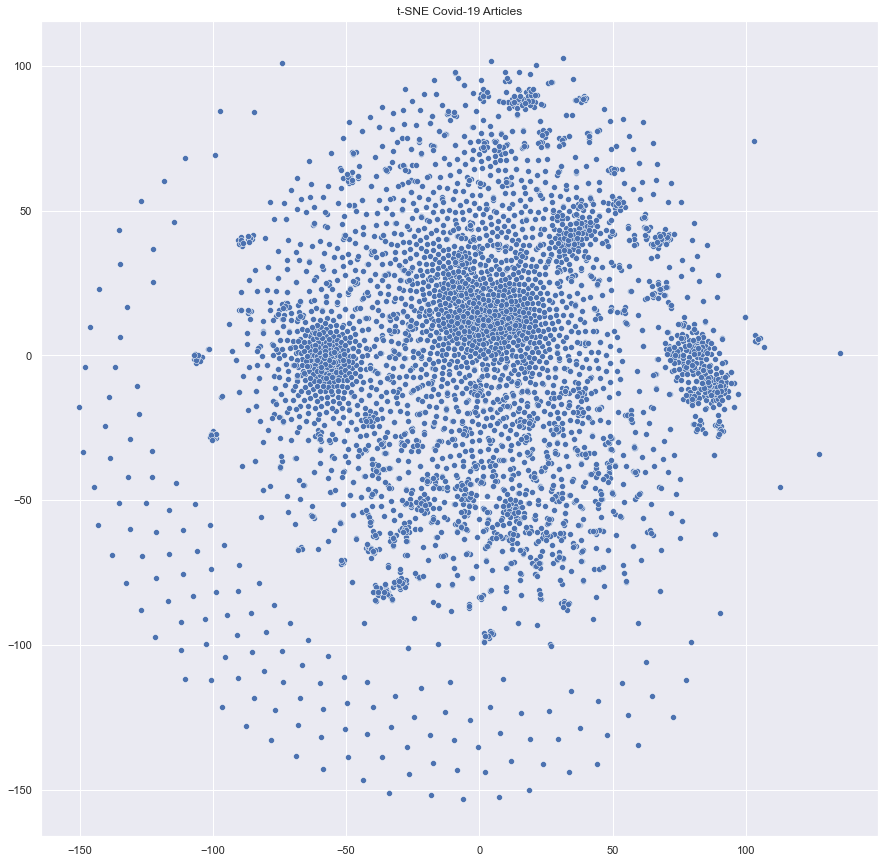

In [61]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)

plt.title("t-SNE Covid-19 Articles")
# plt.savefig("plots/t-sne_covid19.png")
plt.show()

In [70]:
# Following cell will take 4-5 minutes to run

from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, n_jobs=-1, verbose=10)
y_pred = kmeans.fit_predict(X_train)

C:\Users\Michael\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 6102.016151379803
Iteration 1, inertia 3447.3077761592067
Iteration 2, inertia 3432.3651107913097
Iteration 3, inertia 3426.76964083608
Iteration 4, inertia 3420.0242577888225
Iteration 5, inertia 3412.1836469200516
Iteration 6, inertia 3407.6398354085336
Iteration 7, inertia 3405.7769863451445
Iteration 8, inertia 3404.814272039542
Iteration 9, inertia 3404.08468105288
Iteration 10, inertia 3403.4629111369513
Iteration 11, inertia 3402.764198514459
Iteration 12, inertia 3402.4847680407534
Iteration 13, inertia 3402.2628292060895
Iteration 14, inertia 3402.1023760358803
Iteration 15, inertia 3401.9747533931322
Iteration 16, inertia 3401.8893446646402
Iteration 17, inertia 3401.83792980649
Iteration 18, inertia 3401.8121450090675
Iteration 19, inertia 3401.7947264701447
Iteration 20, inertia 3401.7805930053423
Iteration 21, inertia 3401.7661465061638
Iteration 22, inertia 3401.7613857085285
Iteration 23, inertia 3401.759024107354
Iteration 24

Iteration 4, inertia 3398.1662953699492
Iteration 5, inertia 3396.4400518758266
Iteration 6, inertia 3394.9274210900217
Iteration 7, inertia 3393.6295035174944
Iteration 8, inertia 3392.672460633391
Iteration 9, inertia 3392.0624351932624
Iteration 10, inertia 3391.8059975284546
Iteration 11, inertia 3391.691337527771
Iteration 12, inertia 3391.595988006646
Iteration 13, inertia 3391.5329078931263
Iteration 14, inertia 3391.4874208060955
Iteration 15, inertia 3391.44294322982
Iteration 16, inertia 3391.4039494439558
Iteration 17, inertia 3391.369487711
Iteration 18, inertia 3391.334399620731
Iteration 19, inertia 3391.3163245989667
Iteration 20, inertia 3391.309037888484
Iteration 21, inertia 3391.30707913987
Iteration 22, inertia 3391.3053849140815
Converged at iteration 22: strict convergence.
Initialization complete
Iteration 0, inertia 6475.56815670347
Iteration 1, inertia 3476.783883450686
Iteration 2, inertia 3457.871139984599
Iteration 3, inertia 3445.6543214972057
Iteration 4, 

In [71]:
y_train = y_pred

In [72]:
y_test = kmeans.predict(X_test)

C:\Users\Michael\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


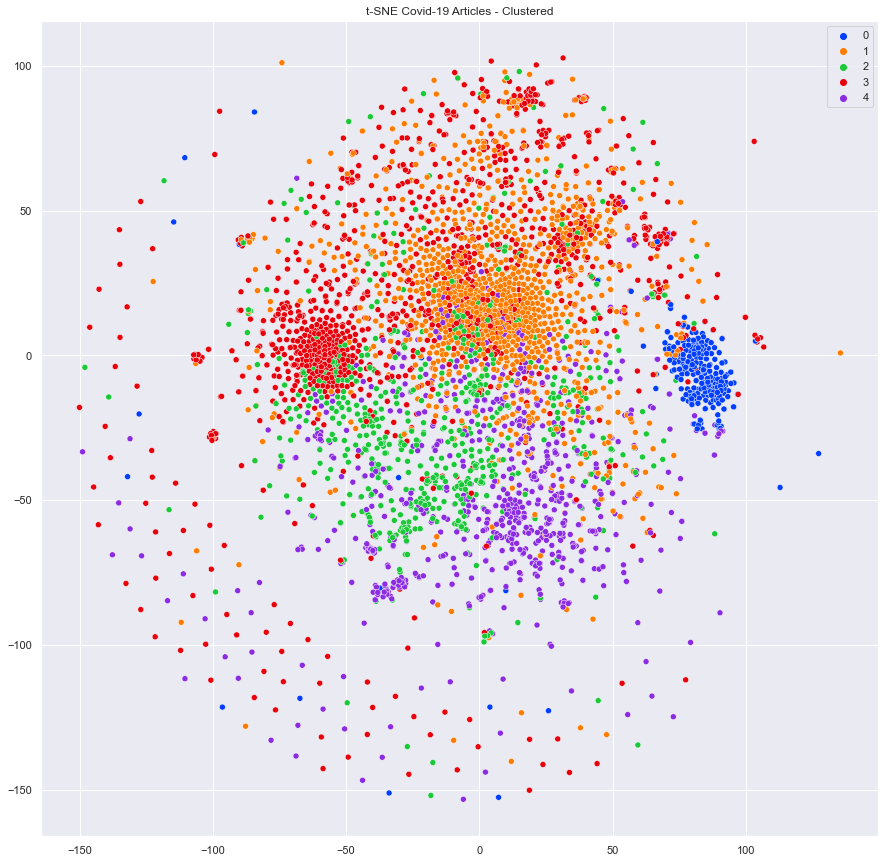

In [73]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
# plt.savefig("plots/t-sne_covid19_label.png")
plt.show()

In [74]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='micro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='micro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='micro')) * 100), "%")

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# random forest classifier instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# cross validation on the training set 
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=3, n_jobs=-1)

# print out the mean of the cross validation scores
print("Accuracy: ", '{:,.3f}'.format(float(forest_scores.mean()) * 100), "%")

Accuracy:  72.589 %


In [76]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score

# cross validate predict on the training set
forest_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, n_jobs=-1)

# print precision and recall scores
print("Precision: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred, average='macro')) * 100), "%")
print("   Recall: ", '{:,.3f}'.format(float(recall_score(y_train, forest_train_pred, average='macro')) * 100), "%")

Precision:  77.430 %
   Recall:  71.709 %


In [77]:
# first train the model
forest_clf.fit(X_train, y_train)

# make predictions on the test set
forest_pred = forest_clf.predict(X_test)

In [78]:
# print out the classification report
classification_report("Random Forest Classifier Report (Test Set)", y_test, forest_pred)

Random Forest Classifier Report (Test Set) :

Accuracy Score:  74.570 %
     Precision:  74.570 %
        Recall:  74.570 %
      F1 score:  74.570 %


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2**12)
X = vectorizer.fit_transform(df_covid['body_text'].values)

In [80]:
X.shape

(5523, 4096)

In [93]:
from sklearn.cluster import MiniBatchKMeans

k = 10
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [94]:
y = y_pred

In [95]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5523 samples in 0.019s...
[t-SNE] Computed neighbors for 5523 samples in 1.013s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5523
[t-SNE] Computed conditional probabilities for sample 2000 / 5523
[t-SNE] Computed conditional probabilities for sample 3000 / 5523
[t-SNE] Computed conditional probabilities for sample 4000 / 5523
[t-SNE] Computed conditional probabilities for sample 5000 / 5523
[t-SNE] Computed conditional probabilities for sample 5523 / 5523
[t-SNE] Mean sigma: 0.217092
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.531631
[t-SNE] KL divergence after 1000 iterations: 2.060581


C:\Users\Michael\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


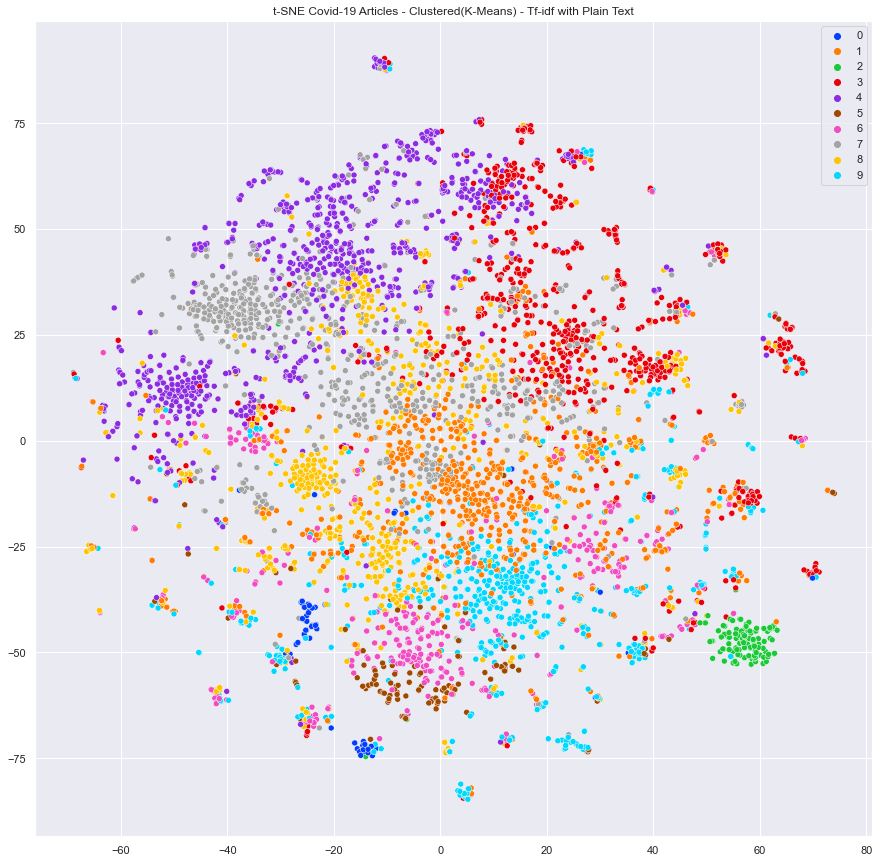

In [96]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/t-sne_covid19_label_TFID.png")
plt.show()

In [97]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X.toarray())

C:\Users\Michael\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


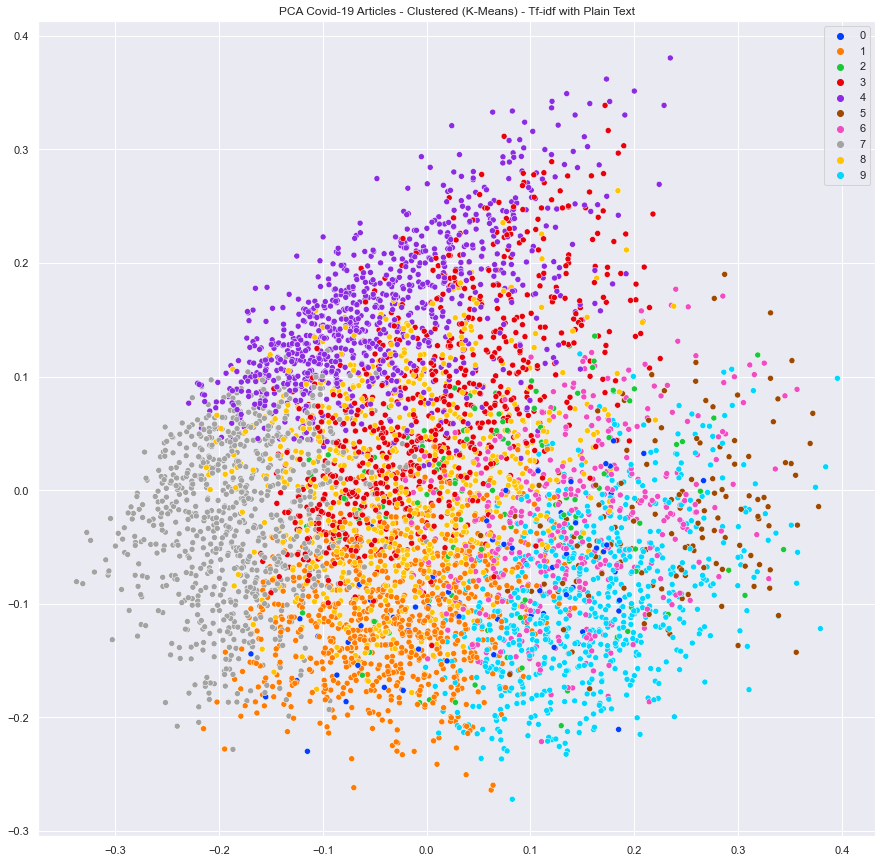

In [98]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=y, legend='full', palette=palette)
plt.title("PCA Covid-19 Articles - Clustered (K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/pca_covid19_label_TFID.png")
plt.show()

C:\Users\Michael\AppData\Local\Temp/ipykernel_78324/3963984120.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


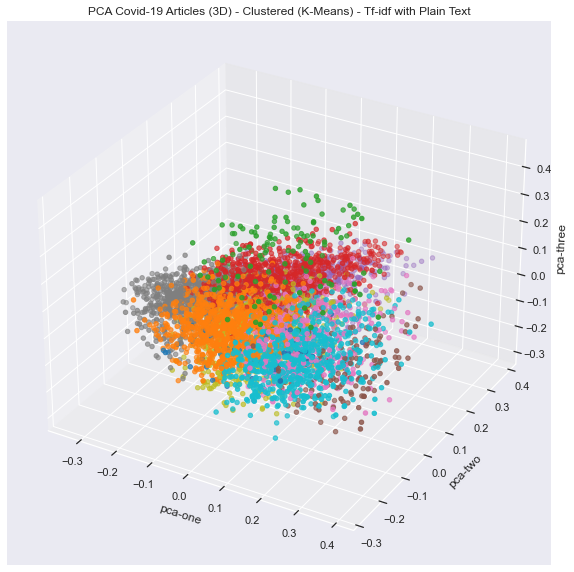

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.title("PCA Covid-19 Articles (3D) - Clustered (K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/pca_covid19_label_TFID_3d.png")
plt.show()

In [100]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
y = y_pred

C:\Users\Michael\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


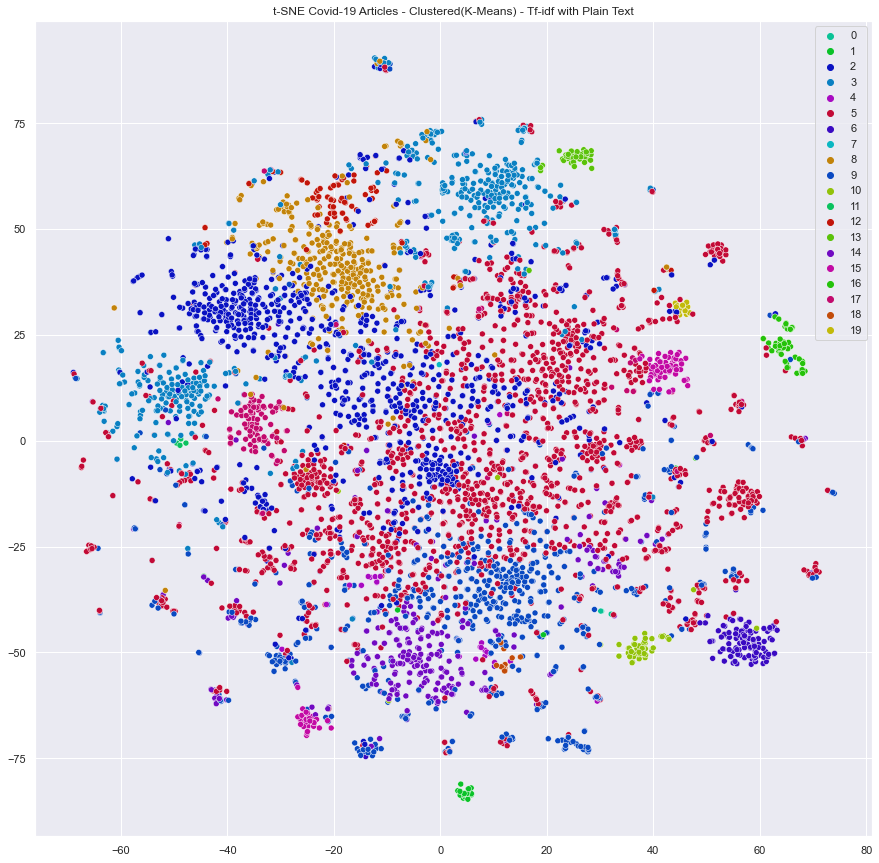

In [101]:
from matplotlib import pyplot as plt
import seaborn as sns
import random 

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# let's shuffle the list so distinct colors stay next to each other
palette = sns.hls_palette(20, l=.4, s=.9)
random.shuffle(palette)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/t-sne_covid19_20label_TFID.png")
plt.show()

In [109]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup
from bokeh.models import TextInput
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.models import Paragraph
from bokeh.layouts import column, widgetbox

output_notebook()
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df_covid['title'],
    authors = df_covid['authors'],
    journal = df_covid['journal'],
    abstract = df_covid['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
],
                 point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="t-SNE Covid-19 Articles, Clustered(K-Means), Tf-idf with Plain Text", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black")

# add callback to control 
callback = CustomJS(args=dict(p=p, source=source), code="""
            
            var radio_value = cb_obj.active;
            var data = source.data; 
            
            x = data['x'];
            y = data['y'];
            
            x_backup = data['x_backup'];
            y_backup = data['y_backup'];
            
            labels = data['desc'];
            
            if (radio_value == '20') {
                for (i = 0; i < x.length; i++) {
                    x[i] = x_backup[i];
                    y[i] = y_backup[i];
                }
            }
            else {
                for (i = 0; i < x.length; i++) {
                    if(labels[i] == radio_value) {
                        x[i] = x_backup[i];
                        y[i] = y_backup[i];
                    } else {
                        x[i] = undefined;
                        y[i] = undefined;
                    }
                }
            }


        source.change.emit();
        """)

# callback for searchbar
keyword_callback = CustomJS(args=dict(p=p, source=source), code="""
            
            var text_value = cb_obj.value;
            var data = source.data; 
            
            x = data['x'];
            y = data['y'];
            
            x_backup = data['x_backup'];
            y_backup = data['y_backup'];
            
            abstract = data['abstract'];
            titles = data['titles'];
            authors = data['authors'];
            journal = data['journal'];

            for (i = 0; i < x.length; i++) {
                if(abstract[i].includes(text_value) || 
                   titles[i].includes(text_value) || 
                   authors[i].includes(text_value) || 
                   journal[i].includes(text_value)) {
                    x[i] = x_backup[i];
                    y[i] = y_backup[i];
                } else {
                    x[i] = undefined;
                    y[i] = undefined;
                }
            }
            


        source.change.emit();
        """)

# option
option = RadioButtonGroup(labels=["C-0", "C-1", "C-2",
                                  "C-3", "C-4", "C-5",
                                  "C-6", "C-7", "C-8",
                                  "C-9", "C-10", "C-11",
                                  "C-12", "C-13", "C-14",
                                  "C-15", "C-16", "C-17",
                                  "C-18", "C-19", "All"], 
                          active=20)

# search box
keyword = TextInput(title="Search:")

#header
header = Div(text="""<h1>COVID-19 Literature Cluster</h1>""")

# show
show(column(header, widgetbox(option, keyword),p))

Loading BokehJS ...